# Graph Neural Network for Jet Constituents Classification

This section presents a Graph Neural Network (GNN) approach for classifying jets as either QCD background or Higgs signal using low-level information from jet constituents. Jets are modeled as graphs, where:

Nodes represent jet constituents (e.g., tracks).

Edges connect all pairs of nodes (fully connected or k-NN) to capture relationships among constituents.

Key highlights:

Constructs graphs using features like ptrel, etarel, phirel, etc.

Uses torch_geometric for graph processing with message-passing layers (e.g., MetaLayer, EdgeConv).

Applies global mean pooling to aggregate node-level information for jet-level classification.

Incorporates mass and pT selection:

Mass: 40 GeV < M<sub>sd</sub> < 200 GeV

Transverse momentum: 300 GeV < p<sub>T</sub> < 2000 GeV

This method is particularly effective in capturing the relational structure of particles within jets, making it a powerful tool in physics-informed machine learning.

In [1]:
# ======================================================================================
# NUMPY for general numerical operations
# ======================================================================================
import numpy as np

# ======================================================================================
# YAML for loading configuration (e.g., feature/label/spectator definitions)
# tqdm.notebook for progress bars in notebooks
# Custom graph dataset loader
# ======================================================================================
import yaml
from tqdm.notebook import tqdm
from utilities.gnn_data_generator import GraphDataset  # your custom dataset class

# ======================================================================================
# Matplotlib + mplhep for HEP-style plots
# Set style to ROOT (CMS-style)
# ======================================================================================
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

# ======================================================================================
# PyTorch: Core neural network building blocks
# ======================================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d  # clean shortcuts

# ======================================================================================
# PyTorch Geometric: GNN layers, datasets, and utilities
# ======================================================================================
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.nn import MetaLayer
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataListLoader  # for multi-GPU training

# Basic GNN layers and pooling
from torch_geometric.nn import EdgeConv, global_mean_pool

# PyTorch Scatter: aggregation operations for graph edges/vertices
from torch_scatter import scatter_mean

# ======================================================================================
# PyTorch utilities for dataset splitting
# ======================================================================================
from torch.utils.data import random_split

# ======================================================================================
# Scikit-learn: evaluation metrics (ROC curve, AUC)
# ======================================================================================
from sklearn.metrics import roc_curve, auc

# ======================================================================================
# OS utilities: manage file paths
# ======================================================================================
import os.path as osp


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
with open('./utilities/definitions_gnn_deepset_adversarial.yml') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
labels = definitions['labels']
spectators = definitions['spectators']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

In [4]:
# ======================================================================================
# Set data source: local files or remote (XRootD/EOS)
# ======================================================================================
local = True  # Set to False if working on EOS (e.g., on CERN lxplus or batch)

if local:
    # Paths to local ROOT files for training, validation, and testing
    file_names = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_10.root']
    file_names_val = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_11.root']
    file_names_test = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_0.root']
else:
    # EOS public remote files for HiggsToBB (QCD background and signal)
    file_names = [
        'root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root'
    ]
    file_names_test = [
        'root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root'
    ]

# ======================================================================================
# Define number of events to load from each dataset
# ======================================================================================
n_events_train = 1000
n_events_val   = 500
n_events_test  = 500

# ======================================================================================
# Instantiate training, validation, and test datasets using GraphDataset
# Each dataset is saved in a subfolder like `gdata_train_60`, where 60 = #features
# Set `n_events_merge = 1` to save one event per `.pt` file (per sample graph)
# ======================================================================================

graph_dataset = GraphDataset(f'gdata_train_{nfeatures}',
                             features,
                             labels,
                             spectators,
                             n_events=n_events_train,
                             n_events_merge=1,
                             file_names=file_names)

graph_dataset_val = GraphDataset(f'gdata_val_{nfeatures}',
                                 features,
                                 labels,
                                 spectators,
                                 n_events=n_events_val,
                                 n_events_merge=1,
                                 file_names=file_names_val)

test_dataset = GraphDataset(f'gdata_test_{nfeatures}',
                            features,
                            labels,
                            spectators,
                            n_events=n_events_test,
                            n_events_merge=1,
                            file_names=file_names_test)


Processing...


  0%|          | 0/309 [00:00<?, ?it/s]

/Users/sashibhusansahoo/Desktop/HEP/boosted_hbb_qcd_analysis/utilities/gnn_data_generator.py:163: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  x = torch.tensor([feature_array[feat][i].to_numpy() for feat in self.features], dtype=torch.float).T
Done!
Processing...


  0%|          | 0/163 [00:00<?, ?it/s]

Done!
Processing...


  0%|          | 0/161 [00:00<?, ?it/s]

Done!


In [5]:
# ======================================================================================
# Define input/output dimensions for the GNN
# inputs  = number of input node features (e.g., 60)
# hidden  = size of hidden layers in MLPs
# outputs = number of output classes (e.g., 2: QCD vs Higgs)
# ======================================================================================
inputs = nfeatures
hidden = 256
outputs = 2

# ======================================================================================
# EdgeBlock: Computes edge features using source and destination node features
# ======================================================================================
class EdgeBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()  # standard parent class init

        self.edge_mlp = Seq(
            Lin(inputs * 2, hidden),         # Input: concatenated src + dest
            BatchNorm1d(hidden),
            ReLU(),
            Lin(hidden, hidden),             # Further transform
            BatchNorm1d(hidden)
        )

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest], dim=1)  # shape: [n_edges, 2*inputs]
        return self.edge_mlp(out)            # shape: [n_edges, hidden]

# ======================================================================================
# NodeBlock: Updates node features using incoming edge messages
# ======================================================================================
class NodeBlock(torch.nn.Module):
    def __init__(self):
        super(NodeBlock, self).__init__()

        self.node_mlp_1 = Seq(
            Lin(inputs + hidden, hidden),    # Combine current node and incoming edge msg
            BatchNorm1d(hidden),
            ReLU(),
            Lin(hidden, hidden),
            BatchNorm1d(hidden)
        )

        self.node_mlp_2 = Seq(
            Lin(inputs + hidden, hidden),    # Again combine and transform
            BatchNorm1d(hidden),
            ReLU(),
            Lin(hidden, hidden),
            BatchNorm1d(hidden)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index                # row: source, col: destination
        out = torch.cat([x[row], edge_attr], dim=1)  # gather source node and edge_attr
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))  # aggregate messages at each node
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

# ======================================================================================
# GlobalBlock: Pool node-level features to form a graph-level representation
# ======================================================================================
class GlobalBlock(torch.nn.Module):
    def __init__(self):
        super(GlobalBlock, self).__init__()

        self.global_mlp = Seq(
            Lin(hidden, hidden),
            BatchNorm1d(hidden),
            ReLU(),
            Lin(hidden, outputs)             # Output layer: logits for 2 classes
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        out = scatter_mean(x, batch, dim=0)  # global mean pooling over graph
        return self.global_mlp(out)          # returns graph-level predictions (logits)

# ======================================================================================
# Full MetaLayer-based GNN model using PyTorch Geometric's MetaLayer
# ======================================================================================
class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()

        # Wrap edge/node/global blocks into one MetaLayer
        self.interactionnetwork = MetaLayer(
            EdgeBlock(),
            NodeBlock(),
            GlobalBlock()
        )

        self.bn = BatchNorm1d(inputs)  # Initial batch norm on input features

    def forward(self, x, edge_index, batch):
        x = self.bn(x)  # normalize node input features
        x, edge_attr, u = self.interactionnetwork(x, edge_index, None, None, batch)
        return u  # `u` is the graph-level output from GlobalBlock

# ======================================================================================
# Instantiate model and optimizer
# ======================================================================================
model = InteractionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


In [6]:
# ======================================================================================
# TEST FUNCTION
# Performs evaluation over the validation/test dataset (no gradients needed)
# ======================================================================================
@torch.no_grad()
def test(model, loader, total, batch_size, leave=False):
    model.eval()  # Set model to evaluation mode (e.g., disables dropout, BN update)

    xentropy = nn.CrossEntropyLoss(reduction='mean')  # Define loss function

    sum_loss = 0.0  # Running total of loss

    # Progress bar over test batches
    t = tqdm(enumerate(loader), total=total / batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)                     # Move batch to GPU/CPU
        y = torch.argmax(data.y, dim=1)            # Get true class index (from one-hot labels)
        batch_output = model(data.x, data.edge_index, data.batch)  # Forward pass
        batch_loss_item = xentropy(batch_output, y).item()         # Compute scalar loss
        sum_loss += batch_loss_item

        t.set_description("loss = %.5f" % batch_loss_item)         # Live loss print
        t.refresh()

    return sum_loss / (i + 1)  # Return average loss over all batches

# ======================================================================================
# TRAIN FUNCTION
# Performs one training epoch over the dataset
# ======================================================================================
def train(model, optimizer, loader, total, batch_size, leave=False):
    model.train()  # Set model to training mode

    xentropy = nn.CrossEntropyLoss(reduction='mean')  # Define loss

    sum_loss = 0.0

    # Progress bar over training batches
    t = tqdm(enumerate(loader), total=total / batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)                      # Move batch to device
        y = torch.argmax(data.y, dim=1)             # Extract target labels
        optimizer.zero_grad()                       # Reset gradients
        batch_output = model(data.x, data.edge_index, data.batch)  # Forward pass
        batch_loss = xentropy(batch_output, y)      # Compute loss
        batch_loss.backward()                       # Backward pass
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)  # Live update
        t.refresh()
        sum_loss += batch_loss_item
        optimizer.step()                            # Update model parameters

    return sum_loss / (i + 1)  # Return average training loss


In [7]:
# ======================================================================================
# Custom collate function to flatten nested list of `Data` objects into a `Batch`
# Required because `GraphDataset.process()` stores data as nested lists: [[Data]]
# ======================================================================================
def collate(items):
    l = sum(items, [])                    # Flatten list of lists: [[Data], [Data]] → [Data, Data, ...]
    return Batch.from_data_list(l)       # Create PyG Batch object from list of graphs

# ======================================================================================
# Set random seed for reproducibility
# ======================================================================================
torch.manual_seed(0)

# ======================================================================================
# Define batch size for training/validation/testing
# ======================================================================================
batch_size = 32

# ======================================================================================
# Setup PyTorch Geometric DataLoaders using `DataListLoader`
# DataListLoader is recommended when using multiple GPUs or .pt files storing lists
# Each loader is passed the `collate` function to ensure correct batch formatting
# ======================================================================================
train_loader = DataListLoader(graph_dataset,
                              batch_size=batch_size,
                              pin_memory=True,
                              shuffle=True)
train_loader.collate_fn = collate

valid_loader = DataListLoader(graph_dataset_val,
                              batch_size=batch_size,
                              pin_memory=True,
                              shuffle=False)
valid_loader.collate_fn = collate

test_loader = DataListLoader(test_dataset,
                             batch_size=batch_size,
                             pin_memory=True,
                             shuffle=False)
test_loader.collate_fn = collate

# ======================================================================================
# Print dataset statistics
# ======================================================================================
full_length   = len(graph_dataset)         # Total number of training samples
train_samples = len(graph_dataset)
valid_samples = len(graph_dataset_val)
test_samples  = len(test_dataset)

print(f"Total trainable data is {train_samples}")
print(f"Data available for validation is {valid_samples}")
print(f"Data available for test is {test_samples}")


Total trainable data is 300
Data available for validation is 160
Data available for test is 158


In [8]:

# ======================================================================================
# Training Loop with Early Stopping and Model Checkpointing
# ======================================================================================

n_epochs = 30               # Max number of training epochs
stable_epochs = 0           # Counts how many epochs validation has not improved
best_valid_loss = 99999     # Initialize best loss to a very high value
patience = 5                # Stop training if no improvement after `patience` epochs

# Progress bar across epochs
t = tqdm(range(0, n_epochs))

for epoch in t:
    # Train on full training set
    loss = train(model, optimizer, train_loader, train_samples, batch_size, 
                 leave=bool(epoch == n_epochs - 1))

    # Validate on validation set
    valid_loss = test(model, valid_loader, valid_samples, batch_size, 
                      leave=bool(epoch == n_epochs - 1))

    # Logging
    print(f'Epoch: {epoch:02d}, Training Loss: {loss:.4f}')
    print(f'    Validation Loss: {valid_loss:.4f}')

    # Check if validation loss improved
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

        # Save the best model
        modpath = osp.join(f'./trained_models/new_models/keras_model_best_gnn_{nfeatures}.pth')
        print(f'New best model saved to: {modpath}')
        torch.save(model.state_dict(), modpath)

        stable_epochs = 0  # Reset counter
    else:
        print('Stable epoch (no improvement)')
        stable_epochs += 1

    # Stop training if validation has not improved for `patience` epochs
    if stable_epochs >= patience:
        print(f'Early stopping after {patience} stable epochs')
        break



  0%|          | 0/30 [00:00<?, ?it/s]

/Users/sashibhusansahoo/miniforge3/envs/hep/lib/python3.10/site-packages/torch/utils/data/dataloader.py:685: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/9.375 [00:00<?, ?it/s]

/var/folders/kt/5gjmmgnd7yb_mpr_xvjm2qhr0000gn/T/ipykernel_74840/95523033.py:47: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Scalar.cpp:23.)
  batch_loss_item = batch_loss.item()


  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 00, Training Loss: 0.5885
    Validation Loss: 3.7250
New best model saved to: ./trained_models/new_models/keras_model_best_gnn_74.pth


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 01, Training Loss: 0.3650
    Validation Loss: 0.9644
New best model saved to: ./trained_models/new_models/keras_model_best_gnn_74.pth


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 02, Training Loss: 0.2572
    Validation Loss: 0.4552
New best model saved to: ./trained_models/new_models/keras_model_best_gnn_74.pth


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 03, Training Loss: 0.2623
    Validation Loss: 0.5125
Stable epoch (no improvement)


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 04, Training Loss: 0.2294
    Validation Loss: 0.4617
Stable epoch (no improvement)


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 05, Training Loss: 0.2896
    Validation Loss: 0.5044
Stable epoch (no improvement)


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 06, Training Loss: 0.2528
    Validation Loss: 0.4479
New best model saved to: ./trained_models/new_models/keras_model_best_gnn_74.pth


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 07, Training Loss: 0.1981
    Validation Loss: 0.4470
New best model saved to: ./trained_models/new_models/keras_model_best_gnn_74.pth


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 08, Training Loss: 0.1586
    Validation Loss: 0.7065
Stable epoch (no improvement)


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 09, Training Loss: 0.1657
    Validation Loss: 0.3634
New best model saved to: ./trained_models/new_models/keras_model_best_gnn_74.pth


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.1274
    Validation Loss: 0.3290
New best model saved to: ./trained_models/new_models/keras_model_best_gnn_74.pth


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 0.2090
    Validation Loss: 0.3822
Stable epoch (no improvement)


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 0.1909
    Validation Loss: 0.3632
Stable epoch (no improvement)


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 0.1730
    Validation Loss: 0.3319
Stable epoch (no improvement)


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 0.1014
    Validation Loss: 0.4011
Stable epoch (no improvement)


  0%|          | 0/9.375 [00:00<?, ?it/s]

  0%|          | 0/5.0 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 0.0965
    Validation Loss: 1.0561
Stable epoch (no improvement)
Early stopping after 5 stable epochs


In [9]:
# ======================================================================================
# Model Evaluation on Test Set
# ======================================================================================

model.eval()  # Set model to evaluation mode (disables dropout, etc.)

# tqdm for live batch progress
t = tqdm(enumerate(test_loader), total=test_samples / batch_size)

# Empty lists to store results from each batch
y_test = []       # True labels
y_predict = []    # Model predictions (softmax probabilities)
spec_test = []    # Spectator features (e.g., mass, pT)

# Loop over test batches
for i, data in t:
    data = data.to(device)  # Move to GPU or CPU

    # Forward pass: get raw output logits from the model
    batch_output = model(data.x, data.edge_index, data.batch)

    # Apply softmax to convert logits → probabilities
    probs = F.softmax(batch_output, dim=1)  # shape: [batch_size, 2]

    # Detach from computation graph and move to CPU for analysis
    y_predict.append(probs.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())     # True labels are one-hot
    spec_test.append(data.u.cpu().numpy())  # Spectator variables (like jet mass, pT)

# ======================================================================================
# Stack all batches into single numpy arrays
# ======================================================================================
y_test = np.concatenate(y_test)         # shape: [N_events, 2]
y_predict = np.concatenate(y_predict)   # shape: [N_events, 2]
spec_test = np.concatenate(spec_test)   # shape: [N_events, N_spec_features]


  0%|          | 0/4.9375 [00:00<?, ?it/s]

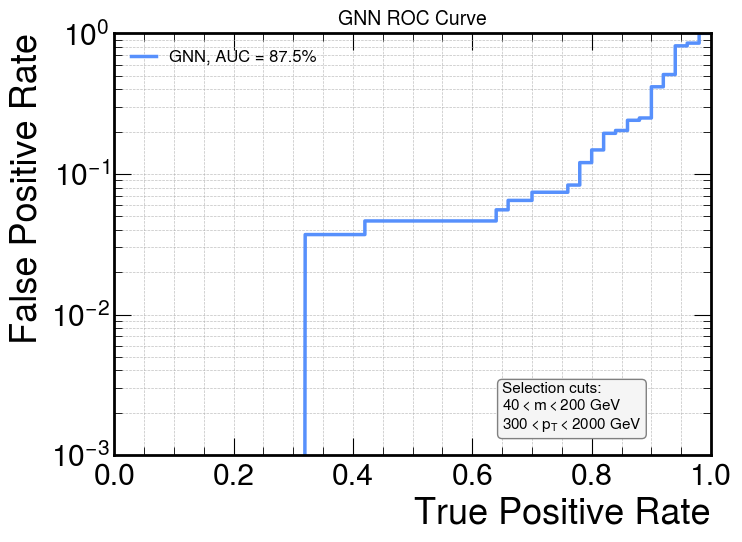

In [10]:
# Calculate ROC and AUC
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:, 1], y_predict[:, 1])
auc_value = auc(fpr_gnn, tpr_gnn) * 100

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc_value))
plt.xlabel(r'True Positive Rate')
plt.ylabel(r'False Positive Rate')
plt.xlim(0, 1)
plt.ylim(0.001, 1)
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.title('GNN ROC Curve', fontsize=14)

# Add mass and pT cut box
cut_text = (
    r"Selection cuts:" + "\n"
    + r"$40 < m < 200$ GeV" + "\n"
    + r"$300 < p_T < 2000$ GeV"
)
plt.gca().text(
    0.65, 0.05, cut_text,
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='whitesmoke', edgecolor='gray')
)

plt.tight_layout()
plt.show()
